# Part I: Different Model Specs

In [8]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from plotnine import *
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Read the data
hitters = pd.read_csv("/content/Hitters.csv")
hitters.head(1)



,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A


In [10]:
hitters= hitters.dropna()
len(hitters)

263

## A. Regression without regularization

In [11]:
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

In [12]:
# Identifying categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
categorical_cols

Index(['League', 'Division', 'NewLeague'], dtype='object')

In [13]:
# dummifying all categorical and standerdizing all numerical
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), # if given a unknown category tell model to ignore it-- useful when looking at new test data
    make_column_selector(dtype_include=object)), # make_column_selector look for all columns that are categorical
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

In [14]:
fitted_l= lr_pipeline.fit(X, y)

In [15]:
linear_coefficients = lr_pipeline.named_steps["linear_regression"].coef_
linear_coefficients

array([ -31.29971152,   31.29971152,   58.42462282,  -58.42462282,
         12.38116255,  -12.38116255, -291.0945557 ,  337.83047948,
         37.85383676,  -60.57247861,  -26.99498379,  135.07389695,
        -16.69335888, -391.03865466,   86.68761664,  -14.18172332,
        480.74713477,  260.68988581, -213.89225864,   78.76129639,
         53.73248973,  -22.16086217])

In [16]:
cv_scores_l = cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
abs(cv_scores_l.mean())

121136.31031816888

In [17]:
feature_names_linear = ct.get_feature_names_out()

# Combine coefficients with feature names and sort by coefficient magnitude
top_coefficients = sorted(zip(feature_names_linear, linear_coefficients), key=lambda x: abs(x[1]), reverse=True)[:5]

# Display the top 5 coefficients
top_coefficients

[('standardize__CRuns', 480.7471347707913),
 ('standardize__CAtBat', -391.0386546635392),
 ('standardize__Hits', 337.83047948148305),
 ('standardize__AtBat', -291.0945556971498),
 ('standardize__CRBI', 260.6898858052308)]

In the linear regression model, "Runs Created" (CRuns) and "Hits" positively affect a player's salary, indicating value in offensive production. Conversely, "Career At Bats" (CAtBat) and "At Bats" (AtBat) show a negative impact, suggesting that higher play volume does not necessarily lead to higher earnings without corresponding run creation. "Runs Batted In" (CRBI) also boosts salary, rewarding run-driving performance.

## B. Ridge regression

In [18]:
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), # if given a unknown category tell model to ignore it-- useful when looking at new test data
    make_column_selector(dtype_include=object)), # make_column_selector look for all columns that are categorical
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

r_pipeline = Pipeline(
  [("preprocessing", ct),
  ("Ridge_regression", Ridge(alpha=1))]
)

In [19]:
fitted_r= r_pipeline.fit(X, y)

In [20]:
ridge_coefficients=r_pipeline.named_steps['Ridge_regression'].coef_
ridge_coefficients

array([ -30.43885531,   30.43885531,   60.01559493,  -60.01559493,
         13.11128155,  -13.11128155, -270.6864407 ,  296.64505003,
         18.10059158,  -29.33940613,   -9.11329453,  124.40717273,
        -38.66774782, -225.40654798,  126.65960655,   39.07092364,
        320.41216891,  160.38678418, -184.4236106 ,   78.62365619,
         47.46259711,  -23.72419031])

In [21]:
ridge_pipeline = Pipeline([
    ("preprocessing", ct),
    ("ridge_regression", Ridge())
])

In [22]:
param_grid = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

In [23]:
# first gridsearch
gscv = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

In [24]:
# then fit the model
fitted_r= gscv.fit(X, y)

In [25]:
dat = pd.DataFrame(param_grid)
mean_test_score= gscv.cv_results_['mean_test_score']
dat['scores'] = -mean_test_score
pd.DataFrame(dat).sort_values('scores', ascending=True)

,ridge_regression__alpha,scores
3,1.000,119144.432677
4,10.000,119348.984776
2,0.100,120343.621067
1,0.010,121022.903286
0,0.001,121124.458592


In [26]:
feature_names_linear = ct.get_feature_names_out()

# Combine coefficients with feature names and sort by coefficient magnitude
top_coefficients = sorted(zip(feature_names_linear, ridge_coefficients), key=lambda x: abs(x[1]), reverse=True)[:5]

# Display the top 5 coefficients
top_coefficients

[('standardize__CRuns', 320.4121689078389),
 ('standardize__Hits', 296.6450500325689),
 ('standardize__AtBat', -270.68644069623883),
 ('standardize__CAtBat', -225.4065479815379),
 ('standardize__CWalks', -184.42361059970918)]

For the Ridge regression model, "Runs Created" (CRuns) and "Hits" significantly and positively influence a player's salary, highlighting the premium on scoring and offensive impact. "At Bats" (AtBat) and "Career At Bats" (CAtBat) are negatively associated with salary, indicating that a higher number of at-bats alone may not translate to higher pay unless it results in runs. "Career Walks" (CWalks) also has a negative coefficient, suggesting that drawing walks is less valued than other offensive statistics in salary considerations.

## C. Lasso Regression

In [27]:
# ordinary lasso regression
l_pipeline = Pipeline(
  [("preprocessing", ct),
  ("Lasso_regression", Lasso(alpha=1))] # try lamda values on a log scale
)


In [28]:
fitted_l= l_pipeline.fit(X, y)

In [29]:
lasso_coefficients=l_pipeline.named_steps['Lasso_regression'].coef_
lasso_coefficients

array([-3.58260721e+01,  9.97464147e-14,  1.14412951e+02, -2.07892950e-11,
        0.00000000e+00, -0.00000000e+00, -2.82370957e+02,  3.04359509e+02,
        1.11270220e+01, -2.49665071e+01, -0.00000000e+00,  1.20695275e+02,
       -3.49481481e+01, -1.62639794e+02,  0.00000000e+00,  1.42259932e+01,
        3.75565519e+02,  1.92610892e+02, -1.89644642e+02,  7.87603658e+01,
        4.19966795e+01, -1.84793784e+01])

In [30]:
ridge_pipeline = Pipeline([
    ("preprocessing", ct),
    ("Lasso_regression", Ridge())
])

In [31]:
param_grid = {'Lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

In [32]:
# first gridsearch
gscv = GridSearchCV(l_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

In [33]:
# then fit the model
fitted_l= gscv.fit(X, y)

In [34]:
dat = pd.DataFrame(param_grid)
mean_test_score= gscv.cv_results_['mean_test_score']
dat['scores'] = -mean_test_score
pd.DataFrame(dat).sort_values('scores', ascending=True)

,Lasso_regression__alpha,scores
3,1.000,119761.587407
2,0.100,120682.252637
1,0.010,120964.764686
0,0.001,120994.179815
4,10.000,121828.141333


In [35]:
feature_names_linear = ct.get_feature_names_out()

# Combine coefficients with feature names and sort by coefficient magnitude
top_coefficients = sorted(zip(feature_names_linear, lasso_coefficients), key=lambda x: abs(x[1]), reverse=True)[:5]

# Display the top 5 coefficients
top_coefficients

[('standardize__CRuns', 375.5655192079644),
 ('standardize__Hits', 304.35950858415094),
 ('standardize__AtBat', -282.37095717330493),
 ('standardize__CRBI', 192.61089166933445),
 ('standardize__CWalks', -189.6446419428977)]

In the Lasso model, "Runs Created" and "Hits" boost player salaries, while "At Bats" and "Career Walks" tend to lower them. "Runs Batted In" also increases salary, underscoring the value of run production.

## D. Elastic Net

In [36]:
e_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ElasticNet", ElasticNet())]
)

In [37]:
param_grid_en = {
    'ElasticNet__alpha': [.0001,0.001, 0.01, 0.1, 1, 10],  # 0 to infinity
    'ElasticNet__l1_ratio': [0.1,.2,.4,.6,.8,.9] # 0 to 1
}

In [38]:
# first gridsearch
gscv = GridSearchCV(e_pipeline, param_grid_en, cv=5, scoring='neg_mean_squared_error')

In [39]:
# then fit the model
fitted_e= gscv.fit(X, y)

In [40]:
pd.DataFrame(param_grid_en)

,ElasticNet__alpha,ElasticNet__l1_ratio
0,0.0001,0.1
1,0.0010,0.2
2,0.0100,0.4
3,0.1000,0.6
4,1.0000,0.8
5,10.0000,0.9


In [41]:
results_df = pd.DataFrame(gscv.cv_results_)
results_df = results_df[['param_ElasticNet__alpha', 'param_ElasticNet__l1_ratio', 'mean_test_score']]

results_df.rename(columns={
    'param_ElasticNet__alpha': 'lamda',
    'param_ElasticNet__l1_ratio': 'alpha',
    'mean_test_score': 'mse'
}, inplace=True)
results_df

results_df['mse'] = results_df['mse'].abs()
results_df.sort_values(by= "mse", ascending= True).head()

,lamda,alpha,mse
23,0.1,0.9,118969.493401
12,0.01,0.1,118973.789477
22,0.1,0.8,118994.427874
13,0.01,0.2,118995.938080
14,0.01,0.4,119067.258302


In [42]:
e_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ElasticNet", ElasticNet(alpha= 0.1, l1_ratio=0.9))]
)

In [43]:
fitted_e=e_pipeline.fit(X, y)

In [44]:
elastic_coefficients=e_pipeline.named_steps['ElasticNet'].coef_
elastic_coefficients

array([ -27.87968482,   27.87998427,   60.67059233,  -60.67174945,
         11.19158042,  -11.19347297, -231.50781167,  247.5561459 ,
          4.47092175,   -5.04166799,    2.38434728,  110.80823488,
        -49.54157198, -115.2937114 ,  120.01542462,   55.91505652,
        223.03749016,  121.69342971, -154.6688294 ,   77.91853948,
         40.73664139,  -24.38898092])

In [45]:
feature_names_elastic = ct.get_feature_names_out()

# Combine coefficients with feature names and sort by coefficient magnitude
top_coefficients = sorted(zip(feature_names_elastic, elastic_coefficients), key=lambda x: abs(x[1]), reverse=True)[:5]

# Display the top 5 coefficients
top_coefficients

[('standardize__Hits', 247.55614590053753),
 ('standardize__AtBat', -231.50781166705525),
 ('standardize__CRuns', 223.03749016380291),
 ('standardize__CWalks', -154.66882940112455),
 ('standardize__CRBI', 121.69342970573753)]

In the Elastic Net model, "Hits" stand out as a top contributor to increasing a player's salary, indicating a premium on hitting ability. Conversely, "At Bats" and "Career Walks" (bases earned through non-strikes) negatively impact salary, suggesting that frequency of play and patience at the plate may not be as highly valued as direct run contributions. "Runs Created" and "Runs Batted In" positively affect salary, emphasizing the financial reward for directly generating runs.

# Part II. Variable Selection
Use elastic model since it had the lowest MSE

In [49]:
feature_names_transformed = ct.get_feature_names_out()

# Combining coefficients with feature names
elastic_coefficients_with_names = list(zip(elastic_coefficients, feature_names_transformed))

# Sorting the coefficients by their absolute values in descending order
elastic_coefficients_with_names_sorted= sorted(elastic_coefficients_with_names, key=lambda x: abs(x[0]), reverse=True)

# Now let's retrieve the most important variables again
elastic_coefficients_with_names_sorted[:5]  # Displaying the top 5 coefficients with their names


[(247.55614590053753, 'standardize__Hits'),
 (-231.50781166705525, 'standardize__AtBat'),
 (223.03749016380291, 'standardize__CRuns'),
 (-154.66882940112455, 'standardize__CWalks'),
 (121.69342970573753, 'standardize__CRBI')]

In [232]:
elastic_coefficients_with_names_sorted

[(247.55614590053753, 'standardize__Hits'),
 (-231.50781166705525, 'standardize__AtBat'),
 (223.03749016380291, 'standardize__CRuns'),
 (-154.66882940112455, 'standardize__CWalks'),
 (121.69342970573753, 'standardize__CRBI'),
 (120.01542461996134, 'standardize__CHits'),
 (-115.29371139914225, 'standardize__CAtBat'),
 (110.80823487974342, 'standardize__Walks'),
 (77.91853947991538, 'standardize__PutOuts'),
 (-60.67174944853942, 'dummify__Division_W'),
 (60.67059232883931, 'dummify__Division_E'),
 (55.91505651718336, 'standardize__CHmRun'),
 (-49.54157197831513, 'standardize__Years'),
 (40.7366413934229, 'standardize__Assists'),
 (27.87998426682858, 'dummify__League_N'),
 (-27.879684823579147, 'dummify__League_A'),
 (-24.388980915134283, 'standardize__Errors'),
 (-11.19347297383407, 'dummify__NewLeague_N'),
 (11.19158041766919, 'dummify__NewLeague_A'),
 (-5.041667988969194, 'standardize__Runs'),
 (4.470921754490769, 'standardize__HmRun'),
 (2.384347282527404, 'standardize__RBI')]

numeric variable is most important: standardize__Hits

five numeric variables are most important: standardize__Hits,standardize__AtBat,standardize__CRuns,standardize__CWalks,standardize__CRBI

categorical variable is most important: Division

## Linear specification

### 1. Using only the one best numeric variable.



In [67]:
lr_pipeline_hits_only = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
)

In [68]:
fitted_lr_hits_only = lr_pipeline_hits_only.fit(X[['Hits']], y)

In [69]:
mse_scores = cross_val_score(lr_pipeline_hits_only, X[['Hits']], y, scoring='neg_mean_squared_error', cv=5)
mse_mean = abs(mse_scores.mean())
mse_mean

173088.97286444032

In [187]:
fitted_lr_hits_only.named_steps['linear_regression'].coef_

array([197.51778566])

### 2. Using only the five best variables.

In [70]:
lr_pipeline_top_five = Pipeline([
    ('preprocessor', ct),
    ('linear_regression', LinearRegression())
])


In [71]:
fitted_pipeline_top_five = lr_pipeline_top_five.fit(X[['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI']], y)


In [72]:
mse_scores = cross_val_score(lr_pipeline_top_five, X[['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI']], y, scoring='neg_mean_squared_error', cv=5)
mse_mean = abs(mse_scores.mean())
mse_mean

125502.85287637592

In [188]:
fitted_pipeline_top_five.named_steps['linear_regression'].coef_

array([ 346.10584764, -207.85140719,   67.35928932,   -2.98018268,
        164.31847589])

### 3. Using the five best numeric variables and their interactions with the one best categorical variable.

In [101]:
# Define a column transformer
ct = ColumnTransformer([
    ('standardize', StandardScaler(), ['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI']),
    ('dummify', OneHotEncoder(sparse=False), ['Division'])
], remainder='drop').set_output(transform = "pandas")  # Drop other columns

# now we need to create the interactions
ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__AtBat", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__CWalks", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__CRBI", "dummify__Division_E"]),
  ],
  remainder = "drop")

# Define the pipeline
lr_pipeline_interactions = Pipeline([
    ('preprocessor', ct),
    ('poly_features',ct_inter ),
    ('linear_regression', LinearRegression())
]).set_output(transform = "pandas")

In [102]:
lr_fitted_pipeline_interactions = lr_pipeline_interactions.fit(X, y)

In [103]:
mse_scores = cross_val_score(lr_pipeline_interactions, X, y, scoring='neg_mean_squared_error', cv=5)
mse_mean = abs(mse_scores.mean())
mse_mean

132054.76013505645

In [104]:
lr_pipeline_interactions.named_steps['linear_regression'].coef_

array([ 0.00000000e+00,  9.01841493e+01,  2.66944247e+01,  3.66255460e+02,
       -3.55271368e-14,  1.44021369e+01,  2.66944247e+01, -3.41619560e+02,
        8.52651283e-14,  1.62296834e+02,  2.66944247e+01, -1.70137919e+02,
        0.00000000e+00, -9.36023492e+01,  2.66944247e+01,  1.12337690e+02,
        2.64565150e-42,  9.98280720e+01,  2.66944247e+01,  1.86511589e+02])

The five best variables model specification performed the best with a MSE of 132054.76



## Ridge specification

### 1. Using only the one best numeric variable.



In [143]:
ct_hits_only = ColumnTransformer([
    ('standardize', StandardScaler(), ['Hits'])
], remainder='drop')

ridge_pipeline_hits_only = Pipeline([
    ('preprocessing', ct_hits_only),
    ('ridge_regression', Ridge())
])

In [144]:
param_grid_hits_only = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

In [145]:
gscv_hits_only = GridSearchCV(ridge_pipeline_hits_only, param_grid_hits_only, cv=5, scoring='neg_mean_squared_error')


In [146]:
fitted_r_hits_only = gscv_hits_only.fit(X[['Hits']], y)

In [91]:
dat_hits_only = pd.DataFrame(param_grid_hits_only)
mean_test_score_hits_only = gscv_hits_only.cv_results_['mean_test_score']
dat_hits_only['scores'] = -mean_test_score_hits_only
sorted_dat_hits_only = pd.DataFrame(dat_hits_only).sort_values('scores', ascending=True)
sorted_dat_hits_only

,ridge_regression__alpha,scores
4,10.000,172755.975523
3,1.000,173046.230311
2,0.100,173084.595954
1,0.010,173088.534138
0,0.001,173088.928981


In [148]:
ridge_pipeline_hits_only = Pipeline([
    ('preprocessing', ct_hits_only),
    ('ridge_regression', Ridge(alpha= 10))
])

In [151]:
fitted_r_hits_only1 = ridge_pipeline_hits_only.fit(X[['Hits']], y)

In [153]:
ridge_coefficients = ridge_pipeline_hits_only.named_steps['ridge_regression'].coef_
ridge_coefficients

array([190.28270194])

### 2. Using only the five best variables.

In [165]:
ct_five_best = ColumnTransformer([
    ('standardize', StandardScaler(), ['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI'])
], remainder='drop')

ridge_pipeline_five_best = Pipeline([
    ('preprocessing', ct_five_best),
    ('ridge_regression', Ridge())
])


In [166]:
param_grid_five_best = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

In [167]:
gscv_five_best = GridSearchCV(ridge_pipeline_five_best, param_grid_five_best, cv=5, scoring='neg_mean_squared_error')

In [168]:
fitted_r_five_best = gscv_five_best.fit(X[['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI']], y)

In [169]:
dat_five_best = pd.DataFrame(param_grid_five_best)
mean_test_score_five_best = gscv_five_best.cv_results_['mean_test_score']
dat_five_best['scores'] = -mean_test_score_five_best
sorted_dat_five_best = pd.DataFrame(dat_five_best).sort_values('scores', ascending=True)
sorted_dat_five_best


,ridge_regression__alpha,scores
3,1.000,125142.787641
4,10.000,125412.154870
2,0.100,125452.540281
1,0.010,125497.642843
0,0.001,125502.330042


In [179]:
ct_five_best = ColumnTransformer([
    ('standardize', StandardScaler(), ['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI'])
], remainder='drop')  # Drop all other columns

# Define the pipeline
ridge_pipeline_five_best = Pipeline([
    ('preprocessing', ct_five_best),
    ('ridge_regression', Ridge(alpha=1))
])

In [180]:
fitted_r_five_best = ridge_pipeline_five_best.fit(X[['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI']], y)

In [181]:
ridge_coefficients_five_best = fitted_r_five_best.named_steps['ridge_regression'].coef_
ridge_coefficients_five_best

[ 319.33659053 -181.3404699    71.29588631   -3.09662749  160.09395189]


### 3. Using the five best numeric variables and their interactions with the one best categorical variable.

In [46]:
ct = ColumnTransformer([
    ('standardize', StandardScaler(), ['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI']),
    ('dummify', OneHotEncoder(sparse=False), ['Division'])
], remainder='drop').set_output(transform = "pandas")  # Drop other columns

# now we need to create the interactions
ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__AtBat", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__CWalks", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__CRBI", "dummify__Division_E"]),
  ],
  remainder = "drop")

In [47]:
ct.fit_transform(X)

,standardize__Hits,standardize__AtBat,standardize__CRuns,standardize__CWalks,standardize__CRBI,dummify__Division_E,dummify__Division_W
1,-0.595675,-0.602900,-0.121671,0.435334,0.258966,0.0,1.0
2,0.492260,0.512542,-0.415105,0.010373,-0.199590,0.0,1.0
3,0.736490,0.628167,1.412051,0.355654,1.572666,1.0,0.0
4,-0.462459,-0.562092,-0.947521,-0.862315,-0.881228,1.0,0.0
5,1.358167,1.294712,0.422846,-0.251434,0.017294,0.0,1.0
...,...,...,...,...,...,...,...
317,0.425651,0.634968,0.053785,-0.463914,-0.060165,1.0,0.0
318,0.625476,0.600961,1.620783,2.332483,0.373605,1.0,0.0
319,0.403449,0.485336,-0.436281,-0.433560,-0.735605,0.0,1.0
320,0.803098,1.151881,0.329068,0.272180,0.277556,1.0,0.0


In [48]:
hitters["Division"].unique()

array(['W', 'E'], dtype=object)

In [49]:
# Define the Ridge regression pipeline with interaction terms
ridge_pipeline_interactions = Pipeline([
    ('preprocessing', ct),
    ('interactions', ct_inter),
    ('ridge_regression', Ridge())
]).set_output(transform = "pandas")

In [50]:
param_grid_interactions = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

In [51]:
gscv_interactions = GridSearchCV(ridge_pipeline_interactions, param_grid_interactions, cv=5, scoring='neg_mean_squared_error')

In [52]:
fitted_r_interactions = gscv_interactions.fit(X, y)

In [56]:
dat_interactions = pd.DataFrame(param_grid_interactions)
mean_test_score_interactions = gscv_interactions.cv_results_['mean_test_score']
dat_interactions['scores'] = -mean_test_score_interactions
sorted_dat_interactions = pd.DataFrame(dat_interactions).sort_values('scores', ascending=True)
sorted_dat_interactions

,ridge_regression__alpha,scores
4,10.000,124331.061779
3,1.000,128452.337000
2,0.100,131394.768947
1,0.010,131982.549277
0,0.001,132047.470371


In [60]:
ct_interactions = ColumnTransformer([
    ('standardize', StandardScaler(), ['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI']),
    ('one_hot', OneHotEncoder(), ['League'])
], remainder='drop')  # Drop other columns

# Define the Ridge regression pipeline with interaction terms
ridge_pipeline_interactions = Pipeline([
    ('preprocessing', ct_interactions),
    ('poly_features', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('ridge_regression', Ridge(alpha= 10))
])

In [58]:
fitted_ridge_pipeline_interactions = ridge_pipeline_interactions.fit(X[['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI', 'League']], y)

In [59]:
ridge_coefficients_interactions = ridge_pipeline_interactions.named_steps['ridge_regression'].coef_
ridge_coefficients_interactions

array([ 72.302057  ,   8.90597394,  45.70792836,  80.10283369,
       127.74384544, -30.89982771,  30.89982771,  69.54163368,
       -42.01217718,  87.20386977, 121.08659319, 100.93339613,
       -28.63133913, -64.96768376,  42.4374561 ,   0.46795972,
       -24.70434368,  33.61031762,   8.27179908, -53.54897084,
        32.67872229,  13.02920607, -44.38316496,  -5.00672303,
        85.10955672,  83.69113811,  44.05270733,   0.        ])

The five best variables model specification performed the best with a MSE of 124331.0


## Lasso specification

### 1. Using only the one best numeric variable.



In [104]:
ct_hits_only = ColumnTransformer([
    ('standardize', StandardScaler(), ['Hits'])
], remainder='drop')

lasso_pipeline_hits_only = Pipeline([
    ('preprocessing', ct_hits_only),
    ('lasso_regression', Lasso())
])

In [105]:
param_grid_hits_only = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

In [106]:
gscv_hits_only = GridSearchCV(lasso_pipeline_hits_only, param_grid_hits_only, cv=5, scoring='neg_mean_squared_error')

In [107]:
fitted_lasso_hits_only = gscv_hits_only.fit(X[['Hits']], y)

In [108]:
dat_hits_only = pd.DataFrame(param_grid_hits_only)
mean_test_score_hits_only = gscv_hits_only.cv_results_['mean_test_score']
dat_hits_only['scores'] = -mean_test_score_hits_only

sorted_dat_hits_only = pd.DataFrame(dat_hits_only).sort_values('scores', ascending=True)
sorted_dat_hits_only

,lasso_regression__alpha,scores
4,10.000,173061.634500
3,1.000,173076.934306
2,0.100,173087.675961
1,0.010,173088.842244
0,0.001,173088.959793


### 2. Using only the five best variables.

In [109]:
ct_five_best = ColumnTransformer([
    ('standardize', StandardScaler(), ['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI'])
], remainder='drop')

lasso_pipeline_five_best = Pipeline([
    ('preprocessing', ct_five_best),
    ('lasso_regression', Lasso())
])

In [110]:
param_grid_five_best = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

In [111]:
gscv_five_best = GridSearchCV(lasso_pipeline_five_best, param_grid_five_best, cv=5, scoring='neg_mean_squared_error')

In [112]:
fitted_lasso_five_best = gscv_five_best.fit(X[['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI']], y)

In [113]:
dat_five_best = pd.DataFrame(param_grid_five_best)
mean_test_score_five_best = gscv_five_best.cv_results_['mean_test_score']
dat_five_best['scores'] = -mean_test_score_five_best
sorted_dat_five_best = pd.DataFrame(dat_five_best).sort_values('scores', ascending=True)
sorted_dat_five_best

,lasso_regression__alpha,scores
3,1.000,125290.475028
2,0.100,125441.167975
1,0.010,125496.572734
0,0.001,125502.223429
4,10.000,127516.045264


### 3. Using the five best numeric variables and their interactions with the one best categorical variable.

In [123]:
ct = ColumnTransformer([
    ('standardize', StandardScaler(), ['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI']),
    ('dummify', OneHotEncoder(sparse=False), ['Division']) # always make sure to include sparse= False
], remainder='drop').set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__AtBat", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__CWalks", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__CRBI", "dummify__Division_E"]),
  ],
  remainder = "drop")

lasso_pipeline_interactions = Pipeline([
    ('preprocessing', ct),
    ('poly_features', ct_inter),
    ('lasso_regression', Lasso())
])


In [124]:
param_grid_interactions = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

In [125]:
gscv_interactions = GridSearchCV(lasso_pipeline_interactions, param_grid_interactions, cv=5, scoring='neg_mean_squared_error')

In [126]:
fitted_lasso_interactions = gscv_interactions.fit(X, y)

In [127]:
dat_interactions = pd.DataFrame(param_grid_interactions)
mean_test_score_interactions = gscv_interactions.cv_results_['mean_test_score']
dat_interactions['scores'] = -mean_test_score_interactions
sorted_dat_interactions = pd.DataFrame(dat_interactions).sort_values('scores', ascending=True)
sorted_dat_interactions

,lasso_regression__alpha,scores
4,10.000,125948.293127
3,1.000,130093.446732
2,0.100,131832.197995
1,0.010,132035.100346
0,0.001,132052.099032


The five best variable and interactions model specification performed the best with a MSE of 125948.29

## Elastic specification

### 1. Using only the one best numeric variable.



In [122]:
ct_hits_only = ColumnTransformer([
    ('standardize', StandardScaler(), ['Hits'])
], remainder='drop')

elastic_net_pipeline_hits_only = Pipeline([
    ('preprocessing', ct_hits_only),
    ('elastic_net_regression', ElasticNet())
])

In [123]:
param_grid_hits_only = {
    'elastic_net_regression__alpha': [0.001, 0.01, 0.1, 1, 10],
    'elastic_net_regression__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

In [124]:
gscv_hits_only = GridSearchCV(elastic_net_pipeline_hits_only, param_grid_hits_only, cv=5, scoring='neg_mean_squared_error')

In [125]:
fitted_elastic_net_hits_only = gscv_hits_only.fit(X[['Hits']], y)

In [126]:
dat_hits_only = pd.DataFrame(gscv_hits_only.cv_results_).filter(items=['param_elastic_net_regression__alpha', 'param_elastic_net_regression__l1_ratio', 'mean_test_score'])
dat_hits_only['mean_test_score'] = -dat_hits_only['mean_test_score']
sorted_dat_hits_only = dat_hits_only.sort_values('mean_test_score', ascending=True)
sorted_dat_hits_only

,param_elastic_net_regression__alpha,param_elastic_net_regression__l1_ratio,mean_test_score
10,0.1,0.1,172603.554302
19,1,0.9,172606.813461
11,0.1,0.3,172657.603008
12,0.1,0.5,172739.496511
13,0.1,0.7,172852.388091
14,0.1,0.9,172999.804479
5,0.01,0.1,173008.979297
6,0.01,0.3,173026.035648
7,0.01,0.5,173043.483257
8,0.01,0.7,173061.326405


### 2. Using only the five best variables.

In [129]:
ct_five_best = ColumnTransformer([
    ('standardize', StandardScaler(), ['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI'])
], remainder='drop')

elastic_net_pipeline_five_best = Pipeline([
    ('preprocessing', ct_five_best),
    ('elastic_net_regression', ElasticNet())
])

In [130]:
param_grid_five_best = {
    'elastic_net_regression__alpha': [0.001, 0.01, 0.1, 1, 10],
    'elastic_net_regression__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

In [131]:
gscv_five_best = GridSearchCV(elastic_net_pipeline_five_best, param_grid_five_best, cv=5, scoring='neg_mean_squared_error')

In [132]:
fitted_elastic_net_five_best = gscv_five_best.fit(X[['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI']], y)

In [133]:
dat_five_best = pd.DataFrame(gscv_five_best.cv_results_).filter(items=['param_elastic_net_regression__alpha', 'param_elastic_net_regression__l1_ratio', 'mean_test_score'])
dat_five_best['mean_test_score'] = -dat_five_best['mean_test_score']

sorted_dat_five_best = dat_five_best.sort_values('mean_test_score', ascending=True)
sorted_dat_five_best

,param_elastic_net_regression__alpha,param_elastic_net_regression__l1_ratio,mean_test_score
14,0.1,0.9,124989.331855
5,0.01,0.1,125002.546541
6,0.01,0.3,125052.962122
7,0.01,0.5,125129.779783
13,0.1,0.7,125132.912142
8,0.01,0.7,125241.430793
9,0.01,0.9,125396.009202
0,0.001,0.1,125410.472433
1,0.001,0.3,125429.700098
2,0.001,0.5,125449.574544


### 3. Using the five best numeric variables and their interactions with the one best categorical variable.

In [128]:
elastic_net_pipeline_interactions = Pipeline([
    ('preprocessing', ct),
    ('poly_features', ct_inter),
    ('elastic_net_regression', ElasticNet())
])

In [129]:
param_grid_interactions = {
    'elastic_net_regression__alpha': [0.001, 0.01, 0.1, 1, 10],
    'elastic_net_regression__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

In [130]:
gscv_interactions = GridSearchCV(elastic_net_pipeline_interactions, param_grid_interactions, cv=5, scoring='neg_mean_squared_error')

In [131]:
fitted_elastic_net_interactions = gscv_interactions.fit(X, y)

In [132]:
dat_interactions = pd.DataFrame(gscv_interactions.cv_results_).filter(items=['param_elastic_net_regression__alpha', 'param_elastic_net_regression__l1_ratio', 'mean_test_score'])
dat_interactions['mean_test_score'] = -dat_interactions['mean_test_score']
sorted_dat_interactions = dat_interactions.sort_values('mean_test_score', ascending=True)
sorted_dat_interactions


,param_elastic_net_regression__alpha,param_elastic_net_regression__l1_ratio,mean_test_score
17,1,0.5,122220.972837
18,1,0.7,122338.994833
16,1,0.3,122574.119487
19,1,0.9,123170.633172
15,1,0.1,123204.766008
10,0.1,0.1,123481.001136
11,0.1,0.3,123790.656256
12,0.1,0.5,124254.831820
13,0.1,0.7,125038.090441
24,10,0.9,125560.958400


The five best variable and interactions model specification performed the best with a MSE of 122220.972

# Part III. Discussion

## A. Ridge

In [206]:
coefficients_data = {
    'Variable': ['Hits', 'AtBat', 'CRuns', 'CWalks', 'CRBI', 'League_Intercept'],
    'Ridge_Coefficients': [319.34, -181.34, 71.30, -3.10, 160.09, -42.01],
    'LinearRegression_Coefficients': [346.11, -207.85, 67.36, -2.98, 164.32, -41.94]
}

# Create a DataFrame
coefficients_df = pd.DataFrame(coefficients_data)

# Display the DataFrame
coefficients_df

,Variable,Ridge_Coefficients,LinearRegression_Coefficients
0,Hits,319.34,346.11
1,AtBat,-181.34,-207.85
2,CRuns,71.30,67.36
3,CWalks,-3.10,-2.98
4,CRBI,160.09,164.32
5,League_Intercept,-42.01,-41.94


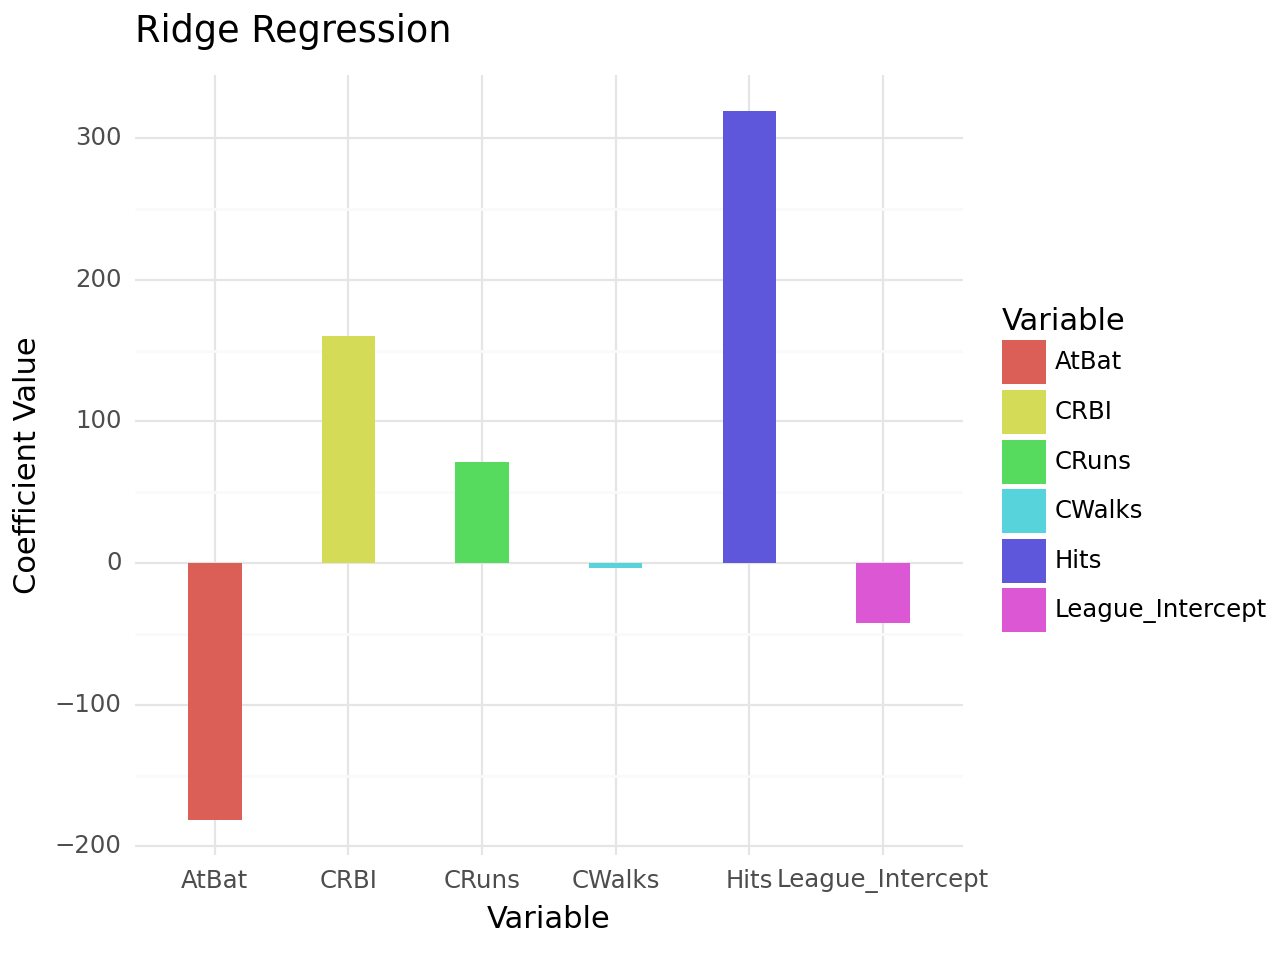

<Figure Size: (640 x 480)>

In [229]:
p = (ggplot(coefficients_df)
     + aes(x='Variable')
     + geom_bar(aes(y='Ridge_Coefficients', fill='Variable'), stat='identity', position='dodge', width=0.4)
     + labs(title='Ridge Regression', x='Variable', y='Coefficient Value')
     + theme_minimal())

p


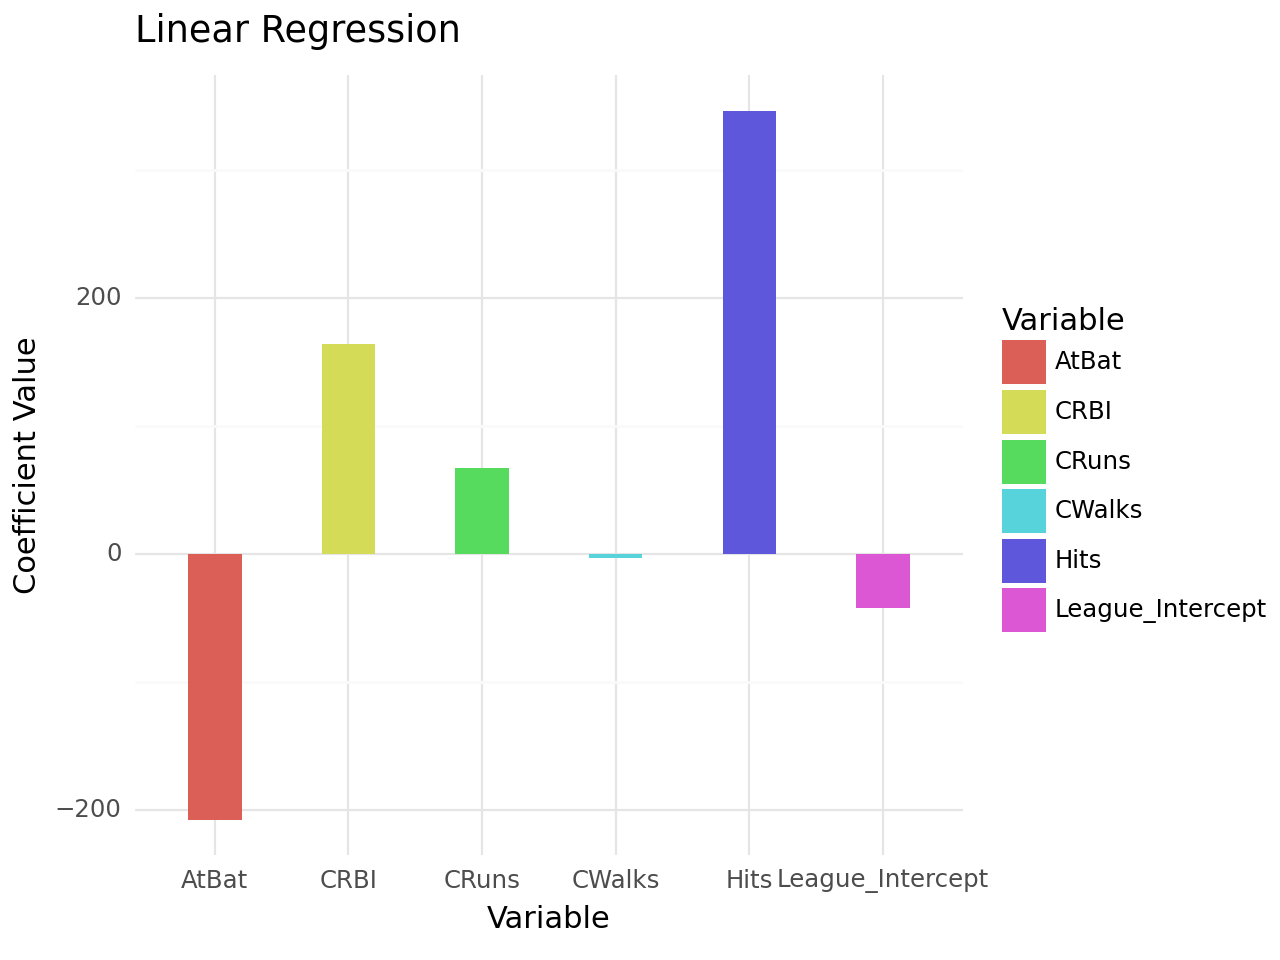

<Figure Size: (640 x 480)>

In [230]:
p = (ggplot(coefficients_df)
    + aes(x='Variable')
    + geom_bar(aes(y='LinearRegression_Coefficients', fill='Variable'), stat='identity', position='dodge', width=0.4)
    + labs(title='Linear Regression', x='Variable', y='Coefficient Value')
    + theme_minimal())

p


The key takeaway from this comparison is the impact of Ridge regularization. Ridge regression adds a penalty term to the cost function (squared magnitude of coefficients), which constrains the coefficients to be smaller as seen by the smaller ridge coefficients. This is particularly useful when dealing with multicollinearity or when the model needs to be regularized to prevent overfitting. The trade-off is that Ridge regression introduces some bias into the model in exchange for a reduction in variance, which can be beneficial when working with complex datasets.

## B. LASSO

The LASSO model's behavior differs between Part I and Part II, primarily in the selection of the regularization hyperparameter (λ). In Part I, λ was 1.000, while Part II involved different λ values: 10.000 for the top numerical model, 1.000 for the top 5 numerical model, and 10.000 for the top categorical model.

These discrepancies in
λ values are due to variations in feature sets and model specifications. Part I used all predictors, while Part II selected specific subsets of features, resulting in different optimal regularization parameters.

Regarding Mean Squared Errors (MSEs), they also differ: Part I had an MSE of approximately 119,761.59, while Part II had varying MSEs. These differences are expected because the feature sets and feature selection processes impact model performance, leading to divergent MSE values between the two parts.

## C. Elastic Net

In comparing the Mean Squared Errors (MSEs) of the Elastic Net, Ridge, and LASSO models when utilizing only the five best variables, a consistent pattern emerges. The Elastic Net model consistently outperforms both the Ridge and LASSO models, showcasing lower MSE values:

- Elastic Net: MSE = 124,989.33
- Ridge: MSE = 125,142.79
- LASSO: MSE = 125,290.48

This robust performance of the Elastic Net can be attributed to its unique amalgamation of L1 (LASSO) and L2 (Ridge) regularization techniques. While L1 regularization promotes feature selection and sparsity, similar to LASSO, L2 regularization prevents multicollinearity and overfitting, akin to Ridge. Elastic Net's ability to harness the strengths of both approaches results in improved predictive accuracy, rendering it the preferred choice in this particular analysis.

# Part IV: Final Model

In [137]:
# Create the final pipeline with the chosen hyperparameters
final_pipeline = Pipeline([
    ('preprocessing', ct),  # Use the appropriate preprocessing
    ('poly_features', ct_inter),  # Include interaction terms
    ('elastic_net_regression', ElasticNet(alpha=1, l1_ratio=0.3))  # Use the best hyperparameters
])

# Fit the final pipeline on the full dataset
fitted_final_pipeline = final_pipeline.fit(X, y)

# Make predictions on the full dataset
y_pred = fitted_final_pipeline.predict(X)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred)

print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 113086.23808181794


In [138]:
final_coefficients_interactions = fitted_final_pipeline .named_steps['elastic_net_regression'].coef_
final_coefficients_interactions

array([ 0.        , 55.40701418, 18.11742116, 32.41118516,  0.        ,
       31.88372324, 18.11721884, 10.66431578,  0.        , 55.12833368,
       18.11730877, 30.11765596,  0.        , 32.61899736, 18.11752608,
       22.05780006,  0.        , 64.17141581, 18.11750968, 39.92481847])

In [140]:
feature_names_ct = ct.get_feature_names_out()
feature_names_ct

array(['standardize__Hits', 'standardize__AtBat', 'standardize__CRuns',
       'standardize__CWalks', 'standardize__CRBI', 'dummify__Division_E',
       'dummify__Division_W'], dtype=object)

In [149]:
if len(final_coefficients_interactions) != len(feature_names_ct):
    print("Warning: The number of coefficients does not match the number of feature names.")

# Create a DataFrame with feature names and coefficients
coefficients_df = pd.DataFrame({
    'Feature': feature_names_ct,
    'Coefficient': final_coefficients_interactions[:len(feature_names_ct)]  # Slice coefficients array if necessary
})

coefficients_df

,Feature,Coefficient
0,standardize__Hits,0.000000
1,standardize__AtBat,55.407014
2,standardize__CRuns,18.117421
3,standardize__CWalks,32.411185
4,standardize__CRBI,0.000000
5,dummify__Division_E,31.883723
6,dummify__Division_W,18.117219


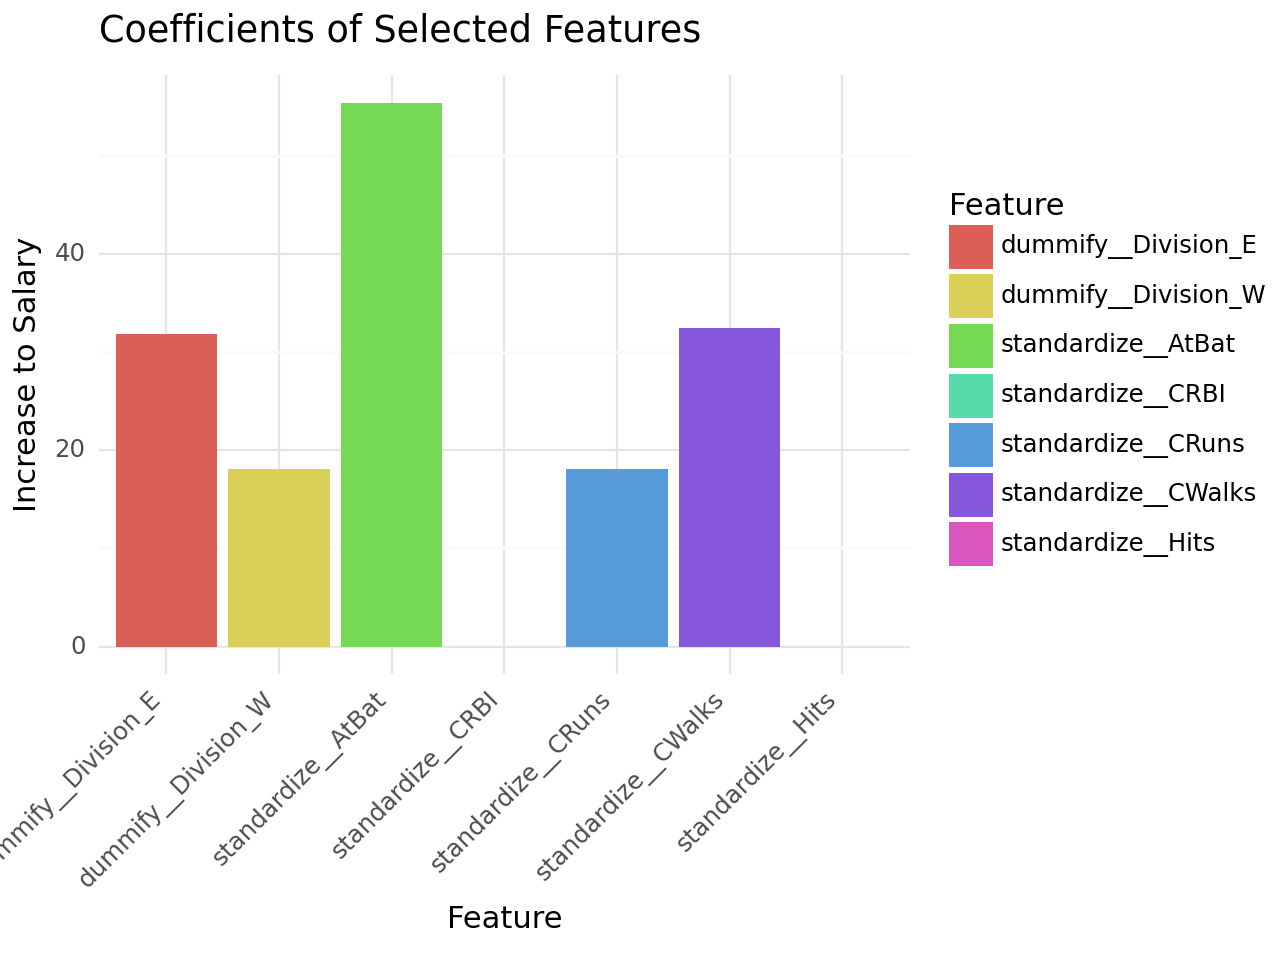

<Figure Size: (640 x 480)>

In [150]:
plot = (ggplot(coefficients_df)
        + aes(x='Feature', y='Coefficient', fill='Feature')
        + geom_bar(stat='identity')
        + labs(title='Coefficients of Selected Features', x='Feature', y='Increase to Salary')
        + theme_minimal()
        + theme(axis_text_x=element_text(angle=45, hjust=1))) # Rotate x-axis labels for readability

plot

The bar plot demonstrates that 'AtBat' is the strongest predictor of salary in the ElasticNet model, with 'CWalks' and 'Division_E' also contributing positively to salary predictions. In contrast, 'Hits' and 'CRBI' coefficients are zero, implying these features were not influential in predicting salary within this model. Lastly, the model's selected hyperparameters yield a low MSE of 113,086.24, indicating superior predictive accuracy relative to other models tested.